# Humor Detection

In [69]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.corpus import wordnet
from nltk.tokenize import PunktSentenceTokenizer # unsupervised machine learning sentence tokenizer , can be trained, but we use the default
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Importing dataset
dataset = pd.read_csv('files/train.csv', nrows=1000)
print(dataset.shape)
print(dataset.head())


(1000, 6)
   id                                               text  is_humor  \
0   1  TENNESSEE: We're the best state. Nobody even c...         1   
1   2  A man inserted an advertisement in the classif...         1   
2   3  How many men does it take to open a can of bee...         1   
3   4  Told my mom I hit 1200 Twitter followers. She ...         1   
4   5  Roses are dead. Love is fake. Weddings are bas...         1   

   humor_rating  humor_controversy  offense_rating  
0          2.42                1.0             0.2  
1          2.50                1.0             1.1  
2          1.95                0.0             2.4  
3          2.11                1.0             0.0  
4          2.78                0.0             0.1  


## Exploratory Data Analysis

### Initial data selection

In [70]:

# selecting important columns only
# dropping 'offense_rating'
dataset = dataset[['id', 'text', 'is_humor', 'humor_rating', 'humor_controversy']]
print(dataset.shape)
print(dataset.head())

print("\n----- Describe ------")
print(dataset.describe())

(1000, 5)
   id                                               text  is_humor  \
0   1  TENNESSEE: We're the best state. Nobody even c...         1   
1   2  A man inserted an advertisement in the classif...         1   
2   3  How many men does it take to open a can of bee...         1   
3   4  Told my mom I hit 1200 Twitter followers. She ...         1   
4   5  Roses are dead. Love is fake. Weddings are bas...         1   

   humor_rating  humor_controversy  
0          2.42                1.0  
1          2.50                1.0  
2          1.95                0.0  
3          2.11                1.0  
4          2.78                0.0  

----- Describe ------
                id     is_humor  humor_rating  humor_controversy
count  1000.000000  1000.000000    616.000000         616.000000
mean    500.500000     0.616000      2.263393           0.517857
std     288.819436     0.486601      0.571492           0.500087
min       1.000000     0.000000      0.100000           0.000000

In [71]:
# checks if there are null values

dataset.isnull().sum()

id                     0
text                   0
is_humor               0
humor_rating         384
humor_controversy    384
dtype: int64

This means we have to process these null values...

In [72]:
dataset[dataset['is_humor']==0].head()

,id,text,is_humor,humor_rating,humor_controversy
5,6,"'Trabajo,' the Spanish word for work, comes fr...",0,NaN,NaN
6,7,I enrolled on some skill training and extra cu...,0,NaN,NaN
8,9,Men who ejaculated 21 times or more a month ha...,0,NaN,NaN
9,10,I got REALLY angry today and it wasn't about n...,0,NaN,NaN
10,11,A dog in Mexico named Frida saved the lives of...,0,NaN,NaN


In [73]:
dataset[dataset['is_humor']==0].shape

(384, 5)

As the number of null values is equal to the rows classifying the text as not humor, dropping these lines would drop important data for the models.

### Data types

In [74]:
dataset.dtypes

id                     int64
text                  object
is_humor               int64
humor_rating         float64
humor_controversy    float64
dtype: object

And it's done! Now some graphics to analyse text statictics... (in progress)

### Text statistics analysis

#### No. of characters by each line

<AxesSubplot:>

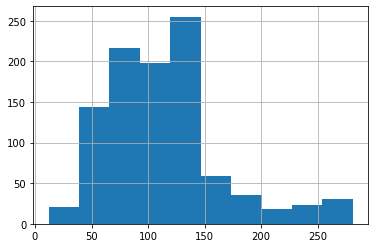

In [75]:
dataset['text'].str.len().hist()

This histogram shows that each line has, generally, between 40 to 150 characters.

#### No. of words by each line

<AxesSubplot:>

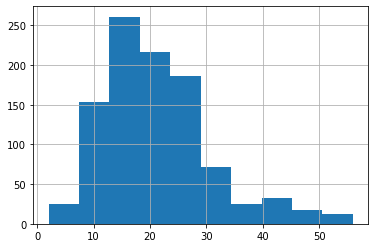

In [76]:
dataset['text'].str.split().\
    map(lambda x: len(x)).\
    hist()

For instance, this histogram shows that each line has, generally, between 10 and 30 words. 

#### Average word length

<AxesSubplot:>

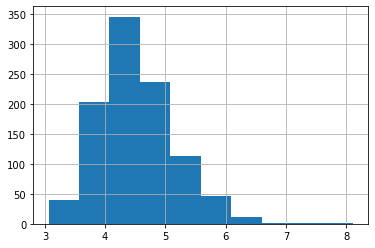

In [77]:
dataset['text'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

This histogram shows that the average word length is mostly, between, 3 to 6 characters (with 4 and 5 being the most common length). So, this may show that the dataset has a high amount of stopwords and analyzing its amount and types can give a good insight about the data.

### Most common stopwords

<BarContainer object of 10 artists>

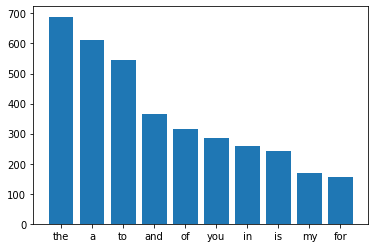

In [79]:
'''https://towardsdatascience.com/exploratory-data-analysis-for-natural-language-processing-ff0046ab3571'''

import matplotlib.pyplot as plt

corpus=[]
stop = set(stopwords.words('english'))
words = dataset['text'].str.split()
words = words.values.tolist()
corpus = [word for i in words for word in i]

from collections import defaultdict
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

This plot shows that is important to remove stopwords, due to its frequency.

### Most common words (excluding stopwords)

After a initial analysis, we concluded that there were some common words with contractions. Therefore, we must first expand these contractions first and plot the common words after.

In [80]:
'''adapted from https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/'''
from collections import Counter
import seaborn as sns

contractions_dict = {
     'I\'m': 'I am',
     'can\'t': 'can not',
     'We\'re': 'We are',
     'wasn\'t': 'was not',
     'you\'ve': 'you have',
     'What\'s': 'What is',
}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# function for expanding contractions
def expand_contractions(text, contractions_dict=contractions_dict):
    return contractions_re.sub(lambda match : contractions_dict[match.group(0)], text)

dataset['text'] = dataset['text'].apply(lambda x : expand_contractions(x))
print(dataset['text'].head(5))

words = dataset['text'].str.split()
words = words.values.tolist()
corpus = [word for i in words for word in i]



0    TENNESSEE: We are the best state. Nobody even ...
1    A man inserted an advertisement in the classif...
2    How many men does it take to open a can of bee...
3    Told my mom I hit 1200 Twitter followers. She ...
4    Roses are dead. Love is fake. Weddings are bas...
Name: text, dtype: object


<AxesSubplot:>

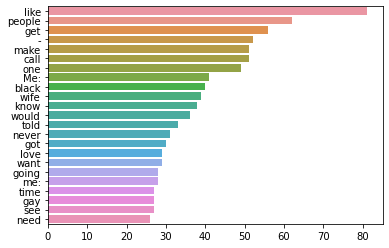

In [81]:
'''https://towardsdatascience.com/exploratory-data-analysis-for-natural-language-processing-ff0046ab3571'''

counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:100]:
    if (word.lower() not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

This plot means that 'me:', 'wife' and 'black', generally indicate that the sentence has humor. (temos que fazer matching disto com o is_humor)

### Humor rating distribution

<AxesSubplot:>

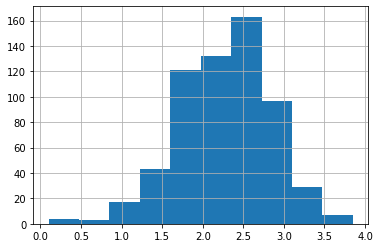

In [82]:
dataset['humor_rating'].hist()

## Data preprocessing

In [83]:


data_list =[]
data_list2 =[]

raw_text =""
stop_words = tuple(set(stopwords.words("english")))

def lemmatization(token_sentence):
    res = []
    for word in token_sentence:
        lemmatizer.lemmatize(word)
        res.append(word)
    return res


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


# Simple test
def input_test(classifier):
    sample_text = input("Enter joke: ")
    sample_text = re.sub(r'[-.?!,:;()|0-9]', ' ', sample_text).lower().split()
    sample_text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in sample_text])
    X = vectorizer.transform([sample_text]).toarray()
    
    #testing------------------------
    dfTesting = pd.DataFrame(X.tolist())
    dfTesting[3973] = float(input("Enter rating: "))
    dfTesting[3974] = int(input("Enter controversy: "))
    X = dfTesting.to_numpy()
    np.nan_to_num(X, copy=False)
    #testing------------------------
    

    print(X.shape)
    print(X)

    if(classifier.predict(X) == [1]):
        print("It's a joke! (+)")
    else:
        print("It's not a joke! (-)")

# range = dataset range
for i in range(0,dataset.shape[0]):
    
   humor_sentence = dataset['text'][i]

   #Tokenization by words or sentences
   humor_sentence = word_tokenize(humor_sentence)
   #remove stopwords and lemmatization with pos_tag
   humor_sentence = " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in humor_sentence if word not in set(stopwords.words('english'))])  
      
   # remove alpha chars/not alphabetical caracters 
   humor_sentence2 = re.sub(r'[-.?!,:;()|0-9]', ' ', dataset['text'][i])
   
   humor_sentence2 = humor_sentence2.lower()
   humor_sentence2 = word_tokenize(humor_sentence2)
   humor_sentence2 = " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in humor_sentence2 if word not in set(stopwords.words('english'))])  
      
   #raw_text += aux_reader+ "\n"
   
    
    # aggregate all the rows of the dataset in one corpus ('data_list')
   data_list.append(humor_sentence)
    
    # how data_list2 is different from data_list?
   data_list2.append(humor_sentence2)


## Extract features from data

In [85]:

# Create bag-of-words model
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer(max_features = 8000)
X = vectorizer.fit_transform(data_list).toarray() # no. of features per phrase (phrase=X[row])
y = dataset.iloc[:,2].values


print(vectorizer.get_feature_names())
print(X.shape, y.shape)


['000', '10', '100', '1000', '100ft', '106', '11th', '12', '1200', '13', '1313', '14', '14gm', '15', '150', '16', '17', '1759', '18', '1800', '1861', '1872', '19', '1930s', '1940', '1945', '1948', '1950s', '1964', '1984', '1995', '1998', '1st', '20', '200', '2000', '2001', '2003', '2013', '2014', '2017', '2018', '2019', '2020', '2052', '21', '2125', '22', '23', '24', '242', '25', '26', '28', '29', '30', '300k', '30pm', '31', '33', '35', '3629', '365', '37', '37th', '3d', '3rd', '40', '40th', '429', '43', '45', '48', '50', '500', '52', '57', '5sos', '60', '63', '666', '6x', '70', '72', '75', '80', '85', '90999', '911', '99', '999', 'aaaaafddasfrwe', 'abc', 'abdul', 'ability', 'able', 'aboard', 'about', 'abraham', 'abroad', 'absent', 'absolutely', 'absorption', 'abulia', 'abuse', 'abuzz', 'academy', 'accent', 'accept', 'acceptance', 'access', 'accessible', 'accident', 'accidentally', 'accord', 'account', 'accountable', 'accuse', 'accuses', 'achievement', 'ackles', 'acne', 'acquire', 'acr

#### Adding more features to the Bag of Words (This makes sense?)

In [86]:
# converting X (numpy array) to a pandas DataFrame
dataset_nlp = pd.DataFrame(X.tolist(), columns=vectorizer.get_feature_names())

# adding 'humor_rating' and 'humor_controversy' columns
dataset_nlp['humor_rating'] = dataset['humor_rating']
dataset_nlp['humor_controversy'] = dataset['humor_controversy']
print(dataset_nlp.head())

X = dataset_nlp.to_numpy()
print(X)
# missing values were replaced by NaN

# replace NaN with 0
np.nan_to_num(X, copy=False)
print(X)

   000  10  100  1000  100ft  106  11th  12  1200  13  ...  yr  zeal  zero  \
0    0   0    0     0      0    0     0   0     0   0  ...   0     0     0   
1    0   0    0     1      0    0     0   0     0   0  ...   0     0     0   
2    0   0    0     0      0    0     0   0     0   0  ...   0     0     0   
3    0   0    0     0      0    0     0   0     1   0  ...   0     0     0   
4    0   0    0     0      0    0     0   0     0   0  ...   0     0     0   

   zombie  zombified  zone  zones  ㅤㅤ  humor_rating  humor_controversy  
0       0          0     0      0   0          2.42                1.0  
1       0          0     0      0   0          2.50                1.0  
2       0          0     0      0   0          1.95                0.0  
3       0          0     0      0   0          2.11                1.0  
4       0          0     0      0   0          2.78                0.0  

[5 rows x 3975 columns]
[[0.   0.   0.   ... 0.   2.42 1.  ]
 [0.   0.   0.   ... 0.   2.5  

## Split dataset into training and test sets

In [87]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 3975) (800,)
(200, 3975) (200,)


## Generate metrics

In [88]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_metrics(y_test, y_pred):
    # confusion matrix
    print(confusion_matrix(y_test, y_pred))

    # accuracy
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    # precision
    print('Precision: ', precision_score(y_test, y_pred))

    # recall
    print('Recall: ', recall_score(y_test, y_pred))

    # f1
    print('F1: ', f1_score(y_test, y_pred))

## Text Classification

In [89]:

# Fit Naive Bayes to the training set

from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predict test set results
y_pred = classifier.predict(X_test)
print_metrics(y_test, y_pred)


[[ 58  22]
 [  3 117]]
Accuracy:  0.875
Precision:  0.841726618705036
Recall:  0.975
F1:  0.9034749034749034


In [90]:
#input_test(classifier)


In [91]:
# SVM

from sklearn.svm import SVC

classifier = SVC()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

[[ 80   0]
 [  2 118]]
Accuracy:  0.99
Precision:  1.0
Recall:  0.9833333333333333
F1:  0.9915966386554621


In [38]:
input_test(classifier)

Enter joke: What word in English language is always spelled incorrectly? Answer : Incorrectly
Enter rating: 0.4
Enter controversy: 0
(1, 3975)
[[0.  0.  0.  ... 0.  0.4 0. ]]
It's not a joke! (-)


In [92]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

[[ 80   0]
 [  1 119]]
Accuracy:  0.995
Precision:  1.0
Recall:  0.9916666666666667
F1:  0.99581589958159


In [93]:
#input_test(classifier)

In [100]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

[[ 70  10]
 [  3 117]]
Accuracy:  0.935
Precision:  0.9212598425196851
Recall:  0.975
F1:  0.9473684210526315


In [101]:
#input_test(classifier)

In [102]:
from sklearn.neural_network import BernoulliRBM
lassifier = BernoulliRBM()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

[[ 71   9]
 [  3 117]]
Accuracy:  0.94
Precision:  0.9285714285714286
Recall:  0.975
F1:  0.951219512195122


In [103]:
#input_test(classifier)

In [104]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

[[ 80   0]
 [  2 118]]
Accuracy:  0.99
Precision:  1.0
Recall:  0.9833333333333333
F1:  0.9915966386554621


In [105]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

[[ 62  18]
 [  1 119]]
Accuracy:  0.905
Precision:  0.8686131386861314
Recall:  0.9916666666666667
F1:  0.926070038910506
